In [59]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import iplot
import plotly.graph_objects as go
import scipy.cluster.hierarchy as sch
import statsmodels.api as sm
from pylab import rcParams
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from fbprophet import Prophet

In [60]:
# import dataframe
df = pd.read_csv('DataFinal.csv', sep=";", decimal=".")
N_COLUMNS = len(df.columns)
N_ROWS = len(df.index)
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(df)

,Дата,Средняя цена авокадо в США (в долларах),Общее количество проданных авокадо (в фунтах),"Количество запросов ""Здоровая еда""","Количество запросов по слову ""Авокадо""",Температура (отклонение от средней)
0,31.01.2015,1.365046,318085209.6,70.50,67.00,0.90
1,28.02.2015,1.326944,362637599.2,63.25,61.75,0.63
2,31.03.2015,1.361981,418583069.8,63.40,60.20,0.67
3,30.04.2015,1.383449,344144395.2,63.75,62.00,0.97
4,31.05.2015,1.344685,483784044.8,62.40,65.60,0.80
5,30.06.2015,1.399074,381826743.7,58.00,65.50,0.82
6,31.07.2015,1.409444,356701872.6,60.50,65.75,0.88
7,31.08.2015,1.444481,419244814.8,55.40,61.40,1.22
8,30.09.2015,1.449144,329218833.1,57.75,50.75,0.99
9,31.10.2015,1.391968,305776111.0,59.00,49.50,1.12


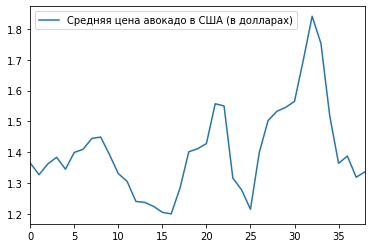

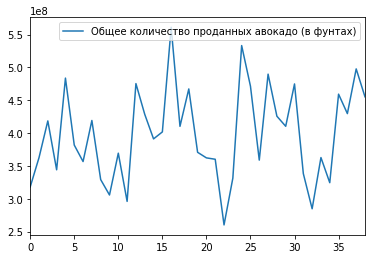

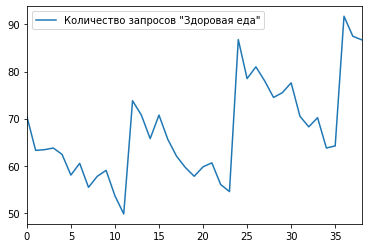

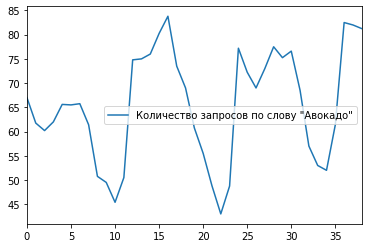

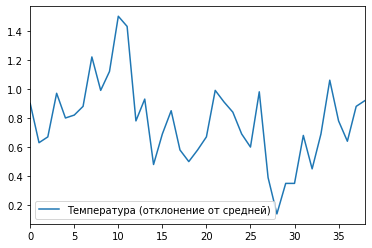

In [61]:
df.plot(y = 'Средняя цена авокадо в США (в долларах)')
df.plot(y = 'Общее количество проданных авокадо (в фунтах)')
df.plot(y = 'Количество запросов "Здоровая еда"')
df.plot(y = 'Количество запросов по слову "Авокадо"')
df.plot(y = 'Температура (отклонение от средней)')

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


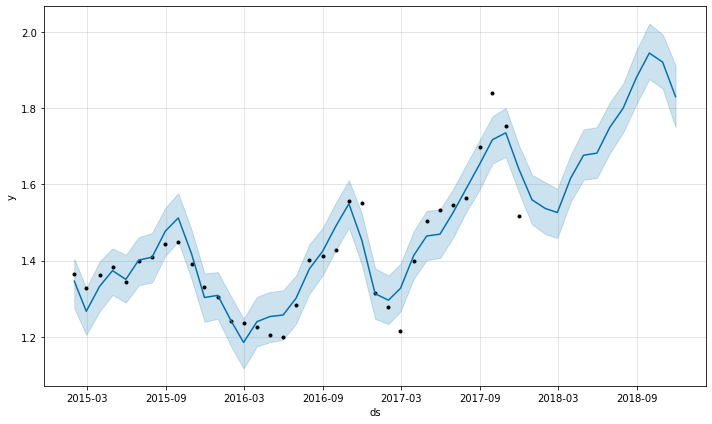

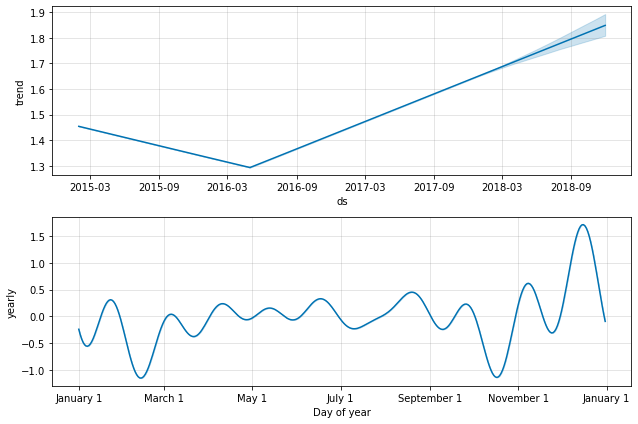

In [62]:
train_df = df[['Средняя цена авокадо в США (в долларах)', 'Дата']].copy()
train_df['y'] = train_df['Средняя цена авокадо в США (в долларах)']
train_df['ds'] = train_df['Дата']
train_df = train_df[:-4]
m = Prophet()
m.fit(train_df)

future = m.make_future_dataframe(periods=12, freq='M')
fcst = m.predict(future)
fig1 = m.plot(fcst)
fig2 = m.plot_components(fcst)

In [63]:
def show_forecast(cmp_df, num_predictions, num_values, axtitle):
    # верхняя граница доверительного интервала прогноза
    upper_bound = go.Scatter(
        name='Upper Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_upper,
        mode='lines',
        marker=dict(color="olive"),
        line=dict(width=0),
        fillcolor='rgba(68, 68, 68, 0.3)',
        fill='tonexty')

    # прогноз
    forecast = go.Scatter(
        name='Prediction',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat,
        mode='lines',
        line=dict(color='rgb(31, 119, 180)'),
    )

    # нижняя граница доверительного интервала
    lower_bound = go.Scatter(
        name='Lower Bound',
        x=cmp_df.tail(num_predictions).index,
        y=cmp_df.tail(num_predictions).yhat_lower,
        marker=dict(color="olive"),
        line=dict(width=0),
        mode='lines')

    # фактические значения
    fact = go.Scatter(
        name='Fact',
        x=cmp_df.tail(num_values).index,
        y=cmp_df.tail(num_values).y,
        marker=dict(color="red"),
        mode='lines',
    )

    data = [lower_bound, upper_bound, forecast, fact]

    layout = go.Layout(
        yaxis=dict(title=axtitle),
        showlegend = False)

    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

df_vis = df[['Средняя цена авокадо в США (в долларах)', 'Дата']].copy()
df_vis['y'] = df_vis['Средняя цена авокадо в США (в долларах)']
df_vis['ds'] = df_vis['Дата']        
cmp_df = fcst.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df_vis.set_index('ds'))    
    
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']    

show_forecast(cmp_df, 50, 50, 'Цена на авокадо в долларах США')

In [64]:
def adf_test(timeseries, lag):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, maxlag=lag)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    

train_df = df['Средняя цена авокадо в США (в долларах)'].copy()
adf_test(train_df, 12)

Results of Dickey-Fuller Test:
Test Statistic                 -2.986463
p-value                         0.036178
#Lags Used                      1.000000
Number of Observations Used    37.000000
Critical Value (1%)            -3.620918
Critical Value (5%)            -2.943539
Critical Value (10%)           -2.610400
dtype: float64


Results of Dickey-Fuller Test:
Test Statistic                 -4.381881
p-value                         0.000320
#Lags Used                      1.000000
Number of Observations Used    36.000000
Critical Value (1%)            -3.626652
Critical Value (5%)            -2.945951
Critical Value (10%)           -2.611671
dtype: float64


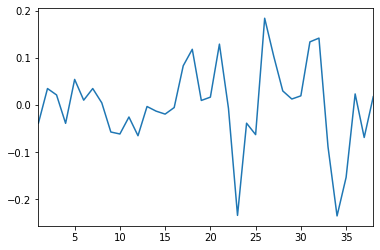

In [65]:
train_df1diff = train_df.diff(1)
train_df1diff = train_df1diff.dropna()
adf_test(train_df1diff, 12)
train_df1diff.plot()

Results of Dickey-Fuller Test:
Test Statistic                 -5.122591
p-value                         0.000013
#Lags Used                      1.000000
Number of Observations Used    24.000000
Critical Value (1%)            -3.737709
Critical Value (5%)            -2.992216
Critical Value (10%)           -2.635747
dtype: float64


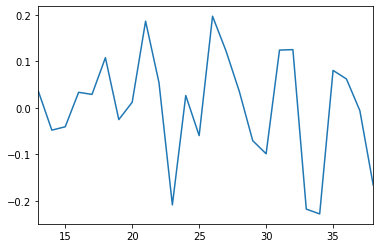

In [66]:
train_df1diff = train_df1diff.diff(12)
train_df1diff = train_df1diff.dropna()
adf_test(train_df1diff, 1)
train_df1diff.plot()

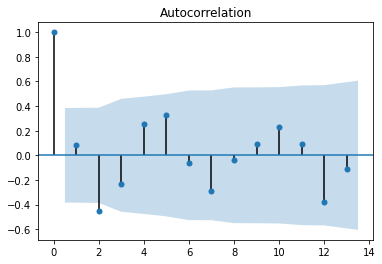

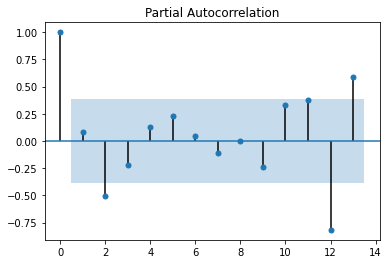

In [67]:
fig1 = sm.graphics.tsa.plot_acf(train_df1diff.values.squeeze(), lags=13)
fig2 = sm.graphics.tsa.plot_pacf(train_df1diff, lags=13)

In [68]:
model = SARIMAX(train_df, order=(2,1,2), seasonal_order=(1,0,1,12)).fit()
model.summary()

D:\ImportantThings\lib\site-packages\statsmodels\base\model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                      Statespace Model Results                                     
===================================================================================================
Dep. Variable:     Средняя цена авокадо в США (в долларах)   No. Observations:                   39
Model:                      SARIMAX(2, 1, 2)x(1, 0, 1, 12)   Log Likelihood                  44.401
Date:                                     Wed, 22 Apr 2020   AIC                            -74.802
Time:                                             00:17:01   BIC                            -63.339
Sample:                                                  0   HQIC                           -70.724
                                                      - 39                                         
Covariance Type:                                       opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8875      0.462      1.923      0.054      -0.017       1.792
ar.L2         -0.1635      0.435     -0.375      0.707      -1.017       0.690
ma.L1         -0.6697      1.178     -0.569      0.570      -2.978       1.639
ma.L2         -0.3244      0.565     -0.574      0.566      -1.433       0.784
ar.S.L12       0.9358      3.334      0.281      0.779      -5.599       7.471
ma.S.L12      -0.8230      5.114     -0.161      0.872     -10.846       9.200
sigma2         0.0051      0.007      0.697      0.486      -0.009       0.019
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 1.11
Prob(Q):                               nan   Prob(JB):                         0.57
Heteroskedasticity (H):               6.08   Skew:                             0.33
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

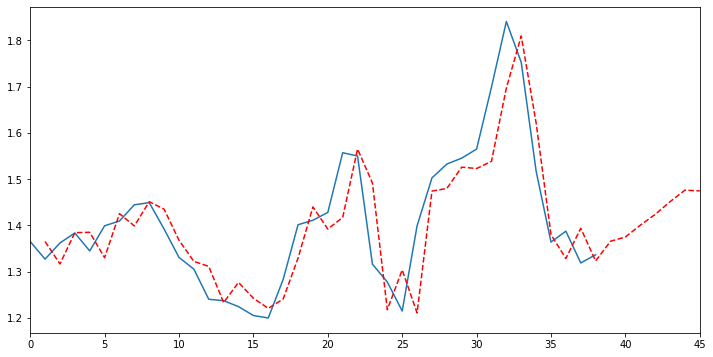

In [69]:
pred = model.predict(1, 45)
df['Средняя цена авокадо в США (в долларах)'].plot(figsize=(12,6))
pred.plot(style='r--')